In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.stats import chi2_contingency


In [2]:
filepath='https://github.com/prabhupanda/ML-code/blob/master/cars_price.csv?raw=true'
prices=pd.read_csv(filepath)

In [3]:
prices.head()

,Unnamed: 0,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


Number of Missing entries in the dataframe

In [4]:
prices.isnull().sum(axis=0)

Unnamed: 0                0
make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              30
color                     0
transmission              0
drive_unit             1345
segment                3755
dtype: int64

In [7]:
print("No. of unique drive_units {}".format(prices['drive_unit'].nunique()))
prices['drive_unit'].value_counts(dropna=False)
#with the highly skewed distribution towards the "four wheel drive" category, imputation maybe done with most ocuuring category

No. of unique drive_units 4


front-wheel drive             27074
rear drive                     4809
all-wheel drive                4176
part-time four-wheel drive     2596
NaN                            1345
Name: drive_unit, dtype: int64

In [8]:
print('No. of Segments : {}'.format(prices['segment'].nunique()))
prices['segment'].value_counts()

No. of Segments : 9


D    8985
C    7509
J    6161
M    4532
E    4391
B    3128
F     658
S     549
A     332
Name: segment, dtype: int64

*Given the high number of missing values in the "segment" and distribution of categories, Imputation will be done by predictive model.*

Check for corelation in the features using Pearson's Correlation

**Imputing the Missing values**

In [15]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='most_frequent',missing_values=np.NaN)
prices['drive_unit']=imputer.fit_transform(prices['drive_unit'].values.reshape(-1,1))

In [16]:
prices.isnull().sum(axis=0)

Unnamed: 0                0
make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)              30
color                     0
transmission              0
drive_unit                0
segment                3755
dtype: int64

In [17]:
prices['drive_unit'].value_counts(dropna=False)

front-wheel drive             28419
rear drive                     4809
all-wheel drive                4176
part-time four-wheel drive     2596
Name: drive_unit, dtype: int64

In [18]:
vol_imputer=SimpleImputer(missing_values=np.nan, strategy='mean')
prices['volume(cm3)']=vol_imputer.fit_transform(prices['volume(cm3)'].values.reshape(-1,1))

Classifier model for imputation

In [19]:
#for imputing values in segment we will crate a classifier model using randomforestclassifier
prices['segment'].value_counts(dropna=False)

D      8985
C      7509
J      6161
M      4532
E      4391
NaN    3755
B      3128
F       658
S       549
A       332
Name: segment, dtype: int64

In [20]:
#iterating through the dataframe to collect the indices of all NaN rows
nan_rows=[]
for index,rows in prices.iterrows():
    is_nan_data=rows.isnull()
    if is_nan_data.any():
        nan_rows.append(index)


In [39]:
prices_encoded=pd.get_dummies(prices.iloc[:,3:])

In [40]:
#getting the test set with NaN segment columns
test_set=prices_encoded.loc[nan_rows,:]
test_set.head()

,priceUSD,year,mileage(kilometers),volume(cm3),condition_for parts,condition_with damage,condition_with mileage,fuel_type_diesel,fuel_type_electrocar,fuel_type_petrol,color_black,color_blue,color_brown,color_burgundy,color_gray,color_green,color_orange,color_other,color_purple,color_red,color_silver,color_white,color_yellow,transmission_auto,transmission_mechanics,drive_unit_all-wheel drive,drive_unit_front-wheel drive,drive_unit_part-time four-wheel drive,drive_unit_rear drive,segment_A,segment_B,segment_C,segment_D,segment_E,segment_F,segment_J,segment_M,segment_S
20,7500,2005,350000.0,1900.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
31,7000,2012,136000.0,2000.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
34,19500,2011,151420.0,5000.0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
47,6500,2005,266.0,2000.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
50,400,1995,195928.0,1600.0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [41]:
#creating the training set
train_set=prices_encoded.drop(index=nan_rows)
train_set.head()

,priceUSD,year,mileage(kilometers),volume(cm3),condition_for parts,condition_with damage,condition_with mileage,fuel_type_diesel,fuel_type_electrocar,fuel_type_petrol,color_black,color_blue,color_brown,color_burgundy,color_gray,color_green,color_orange,color_other,color_purple,color_red,color_silver,color_white,color_yellow,transmission_auto,transmission_mechanics,drive_unit_all-wheel drive,drive_unit_front-wheel drive,drive_unit_part-time four-wheel drive,drive_unit_rear drive,segment_A,segment_B,segment_C,segment_D,segment_E,segment_F,segment_J,segment_M,segment_S
0,565,1993,960015.0,2000.0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
1,5550,2008,172000.0,1400.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,8300,2008,223000.0,2500.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,3300,2005,140000.0,1200.0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
4,2450,2002,413000.0,2200.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0


In [42]:
train_set.shape

(36245, 38)

In [48]:
X=train_set.iloc[:,0:29].values
y=train_set.iloc[:,29:].values
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()
classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
predict_x=test_set.iloc[:,0:29].values
predictions=classifier.predict(predict_x)

In [50]:
predictions

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [51]:
classes=np.argmax(predictions,axis=-1)

In [52]:
classes

array([7, 0, 0, ..., 8, 6, 2])

In [54]:
test_set['segment_prediction']=classes

In [57]:
test_set['segment_prediction'].replace(to_replace=[0,1,2,3,4,5,6,7,8],value=['A','B','C','D','E','F','J','M','S'],inplace=True)

In [ ]:
test_set.head()

In [ ]:
#replacing the NaN values with predictions 
final_pred=prices.loc[nan_rows,:]
final_pred.head()

In [ ]:
final_pred['segment']=test_set['segment_prediction']
final_pred.head()

In [61]:
train_seg=prices.drop(index=nan_rows)
final_df=pd.concat([train_seg,final_pred],axis=0,sort=True)

In [63]:
final_df.sort_index(axis=0,inplace=True)
final_df.head(25)

,Unnamed: 0,color,condition,drive_unit,fuel_type,make,mileage(kilometers),model,priceUSD,segment,transmission,volume(cm3),year
0,0,black,with mileage,front-wheel drive,petrol,honda,960015.0,accord,565,D,mechanics,2000.0,1993
1,1,silver,with mileage,front-wheel drive,diesel,ford,172000.0,fusion,5550,M,mechanics,1400.0,2008
2,2,purple,with mileage,front-wheel drive,petrol,nissan,223000.0,teana,8300,D,auto,2500.0,2008
3,3,blue,with mileage,front-wheel drive,petrol,volkswagen,140000.0,fox,3300,A,mechanics,1200.0,2005
4,4,burgundy,with damage,front-wheel drive,diesel,nissan,413000.0,primera,2450,D,mechanics,2200.0,2002
5,5,black,with mileage,front-wheel drive,diesel,nissan,148000.0,x-trail,18900,J,mechanics,1600.0,2016
6,6,green,with mileage,front-wheel drive,petrol,mitsubishi,378194.9,galant,2000,D,auto,2000.0,1997
7,7,green,with mileage,front-wheel drive,diesel,volkswagen,245000.0,golf,5950,C,auto,1900.0,2002
8,8,burgundy,with mileage,front-wheel drive,petrol,volkswagen,400000.0,passat,3200,D,mechanics,1800.0,1991
9,9,gray,with mileage,front-wheel drive,petrol,renault,210000.0,vel-satis,4700,E,auto,2000.0,2004


In [64]:
final_df.isnull().sum(axis=0)

Unnamed: 0             0
color                  0
condition              0
drive_unit             0
fuel_type              0
make                   0
mileage(kilometers)    0
model                  0
priceUSD               0
segment                0
transmission           0
volume(cm3)            0
year                   0
dtype: int64

# **EDA on the final DATASET**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


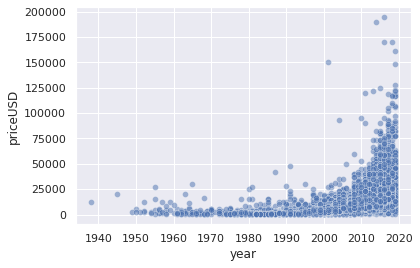

In [13]:
sns.scatterplot(prices['year'],prices['priceUSD'],alpha=0.5)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


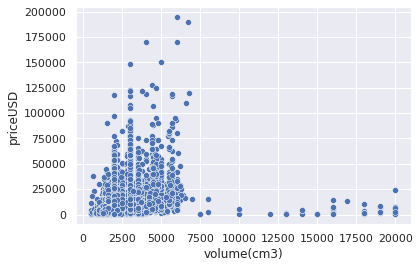

In [14]:
sns.scatterplot(prices['volume(cm3)'],prices['priceUSD'])

In [10]:
corr_matrix=prices.corr(method='pearson')

Plotting Correlation Matrix

No strong Correlation between the numeric features


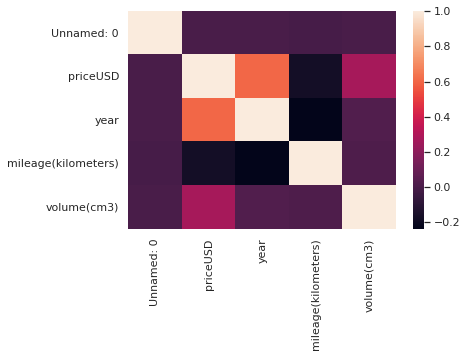

In [11]:
#plotting the coorelation matrix for visualization
sns.heatmap(corr_matrix)
print("No strong Correlation between the numeric features")

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


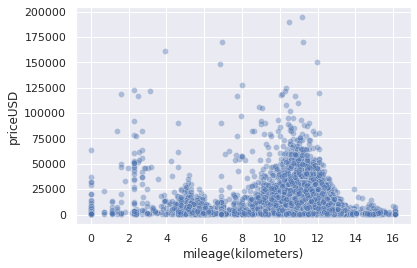

In [12]:
sns.scatterplot(np.log(prices['mileage(kilometers)']),prices['priceUSD'],alpha=0.4)

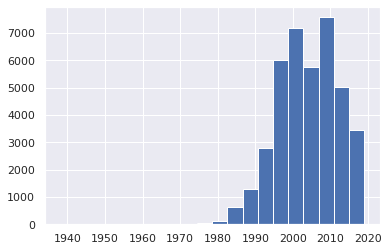

In [5]:
plt.hist(prices['year'],bins=20)
plt.show()

#test shows transmission and segment type arent dependent

In [66]:
#Chi-squared test for hypothesis testing
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(pd.get_dummies(final_df['transmission']),pd.get_dummies(final_df['segment']))
alpha=0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)')  

p value is 0.49764920686884595
Independent (H0 holds true)
